In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn import tree
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import TruncatedSVD
import xgboost, lightgbm
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import string
from textblob import TextBlob

In [2]:
train_txt = pd.read_csv("training_text",sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
test_txt = pd.read_csv("test_text",sep='\|\|', header=None, names=["ID","Text"])
train_var = pd.read_csv("training_variants",sep=',')
test_var = pd.read_csv("test_variants",sep=',',header=None,names=['ID', 'Gene', 'Variation', 'Class'])

D:\Prog_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
D:\Prog_files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
print('train_txt',train_txt.shape)
print('test_txt',test_txt.shape)
print('train_var',train_var.shape)
print('test_var',test_var.shape)

train_txt (3321, 2)
test_txt (368, 2)
train_var (3321, 4)
test_var (368, 4)


In [4]:
train_set = pd.merge(train_var,train_txt,how='inner',on='ID')
train_set = train_set[['ID', 'Gene', 'Variation', 'Text', 'Class']]
train_set.dropna(inplace=True)
train_set.reset_index(inplace=True)
# train_set.drop(columns=['ID','index'],axis=1,inplace=True)
train_set.drop(columns=['index'],axis=1,inplace=True)
print(train_set.shape)
train_set.head(5)

(3316, 5)


,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


In [ ]:
test_set = pd.merge(test_var,test_txt,how='inner',on='ID')
test_set = test_set[['ID', 'Gene', 'Variation', 'Text', 'Class']]
test_set.dropna(inplace=True)
test_set.reset_index(inplace=True)
# test_set.drop(columns=['ID','index'],axis=1,inplace=True)
test_set.drop(columns=['index'],axis=1,inplace=True)
print(test_set.shape)
test_set.head(5)

In [6]:
# train_set.describe(include = 'all')
# test_set.describe(include = 'all')

,ID,Gene,Variation,Text,Class
count,3316.000000,3316,3316,3316,3316.000000
unique,NaN,262,2993,1920,NaN
top,NaN,BRCA1,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...,NaN
freq,NaN,264,92,53,NaN
mean,1660.034077,NaN,NaN,NaN,4.366104
std,959.287860,NaN,NaN,NaN,2.309241
min,0.000000,NaN,NaN,NaN,1.000000
25%,828.750000,NaN,NaN,NaN,2.000000
50%,1661.500000,NaN,NaN,NaN,4.000000
75%,2490.250000,NaN,NaN,NaN,7.000000


In [ ]:
train_gene = train_set['Gene'].unique()
print('count_train_gene =',len(train_gene))
test_gene = test_set['Gene'].unique()
print('count_test_gene =',len(test_gene))

In [ ]:
train_variation = train_set['Variation'].unique()
print('count_train_variation =',len(train_variation))
test_variation = test_set['Variation'].unique()
print('count_test_variation =',len(test_variation))

In [6]:
def get_char_info(text):
    txt_split = re.split('[0-9]*',text)
    txt_split = [i for i in txt_split if i != '']
    if len(txt_split) == 0: first_char, second_char, third_char = '','',''
    elif len(txt_split) == 1: first_char, second_char, third_char = txt_split[0],'',''
    elif len(txt_split) == 2: first_char, second_char, third_char = txt_split[0],txt_split[1],''
    elif len(txt_split) == 3: first_char, second_char, third_char = txt_split[0],txt_split[1],txt_split[2]
    return first_char, second_char, third_char

In [7]:
def get_num_info(text):
    txt_split = re.split('[A-Z]*',text)
    txt_split = [i for i in txt_split if i != '']
    if len(txt_split) == 0: first_num, second_num, third_num = 0,0,0
    elif len(txt_split) == 1: first_num, second_num, third_num = int(txt_split[0]),0,0
    elif len(txt_split) == 2: first_num, second_num, third_num = int(txt_split[0]),int(txt_split[1]),0
    elif len(txt_split) == 3: first_num, second_num, third_num = int(txt_split[0]),int(txt_split[1]),int(txt_split[2])
    return first_num, second_num, third_num

In [8]:
def gene_features(gene):
    first_char, second_char, third_char = get_char_info(gene)
    first_num, second_num, third_num = get_num_info(gene)
    len_char1 = len(first_char)
    len_char2 = len(second_char)
    len_char3 = len(third_char)
    if len_char1 > 0 : gene_char1 = first_char[0]
    else: gene_char1 = ' '
    if len_char2 > 0 : gene_char2 = second_char[0]
    else: gene_char2 = ' '
    if len_char3 > 0 : gene_char3 = third_char[0]
    else: gene_char3 = ' '
    return gene_char1, len_char1, gene_char2, len_char2, gene_char3, len_char3, first_num, second_num, third_num

In [9]:
# extract pure numbers
def extract_num_frm_text(text):
    m = re.search(' [0-9]* ',text)
    if m is not None:
        number = int(m.group())
        sp = text.split(m.group())
        other = ' '.join(sp)
    else:
        number = 0
        other = text
    return number, other

In [10]:
#only text 
def extract_pure_text_frm_text(text):
    txt_splits = re.split(' ',text)
    pure,non_pure = [],[]
    for txt in txt_splits:
        m = re.search('[A-Z][a-z]*|[a-z/]*',txt)
        if m is not None and m.group() == txt:
            pure.append(txt)
        else: non_pure.append(txt)
    pure_text = ' '.join(pure)
    non_pure_text = ''.join(non_pure)
    return pure_text,non_pure_text

In [11]:
def extract_category_combination_from_text(text):
    rep = re.sub('\_|\?|\'|\*|\-','',text)
    cat = ''.join(re.split('[A-Z0-9]*',rep))
    comb = ''.join(re.split('[a-z]*',rep))
    return cat,comb

In [12]:
def gene_and_variations_features(df):
    for i in range(len(df)):
        variation = df.loc[i,'Variation']
        gene = train_set.loc[i,'Gene']
        number, other = extract_num_frm_text(variation)
        pure_text, non_pure_text = extract_pure_text_frm_text(other)
        cat, comb = extract_category_combination_from_text(non_pure_text)
        v_char1,v_len1,v_char2,v_len2,v_char3,v_len3,v_num1,v_num2,v_num3 = gene_features(comb)
        gene = re.sub('\_|\?|\'|\*|\-','',gene)
        g_char1,g_len1,g_char2,g_len2,g_char3,g_len3,g_num1,g_num2,g_num3 = gene_features(gene)
        df.loc[i,'var_number'] = number
        df.loc[i,'var_pure_text'] = pure_text
        df.loc[i,'var_category'] = cat
        df.loc[i,'var_combination'] = comb
        df.loc[i,'var_comb_char1'] = v_char1
        df.loc[i,'var_comb_char1_len'] = v_len1
        df.loc[i,'var_comb_char2'] = v_char2
        df.loc[i,'var_comb_char2_len'] = v_len2
        df.loc[i,'var_comb_char3'] = v_char3
        df.loc[i,'var_comb_char3_len'] = v_len3
        df.loc[i,'var_comb_num1'] = v_num1
        df.loc[i,'var_comb_num2'] = v_num2
        df.loc[i,'var_comb_num3'] = v_num3
        df.loc[i,'gene_char1'] = g_char1
        df.loc[i,'gene_char1_len'] = g_len1
        df.loc[i,'gene_char2'] = g_char2
        df.loc[i,'gene_char2_len'] = g_len2
        df.loc[i,'gene_char3'] = g_char3
        df.loc[i,'gene_char3_len'] = g_len3
        df.loc[i,'gene_num1'] = g_num1
        df.loc[i,'gene_num2'] = g_num2
        df.loc[i,'gene_num3'] = g_num3
    return df

In [ ]:
train_txt =  train_set[['ID','Text']]
train_set.drop(columns='Text',inplace=True)
test_txt =  test_set[['ID','Text']]
test_set.drop(columns='Text',inplace=True)
print(train_set.shape)
print(test_set.shape)

In [ ]:
train_set_mod = gene_and_variations_features(train_set)
test_set_mod = gene_and_variations_features(test_set)

In [ ]:
train_set_mod = train_set_mod.drop(columns=['Gene', 'Variation','var_combination'])
test_set_mod = test_set_mod.drop(columns=['Gene', 'Variation', 'var_combination'])
train_set_mod.columns

In [13]:
# train_set_new.describe(include='all')
cat_columns = ['var_category', 'var_comb_char1', 'var_comb_char2', 'var_comb_char3', 
               'gene_char1', 'gene_char2', 'gene_char3']
print(train_set_mod.shape)

(3316, 136)


In [ ]:
for col in cat_columns:
    cat_features = train_set_mod[col]
    test_cat_features = test_set_mod[col]
    enc = LabelEncoder()
    cat_features = enc.fit_transform(cat_features)
    cat_features = cat_features.reshape(-1, 1) # Needs to be the correct shape
    test_cat_features = enc.transform(test_cat_features)
    test_cat_features = test_cat_features.reshape(-1, 1) # Needs to be the correct shape
    ohe = OneHotEncoder(sparse=False) #Easier to read
    cat_matrix = ohe.fit_transform(cat_features)
    test_cat_matrix = ohe.transform(test_cat_features)
    cat_matrix_df = pd.DataFrame(cat_matrix,columns = col+'_'+enc.classes_)
    test_cat_matrix_df = pd.DataFrame(test_cat_matrix,columns = col+'_'+enc.classes_)
    train_set_mod = train_set_mod.merge(cat_matrix_df, how='inner',left_index=True, right_index=True)
    test_set_mod = test_set_mod.merge(test_cat_matrix_df, how='inner',left_index=True, right_index=True)
    print(col,len(enc.classes_))
    print(train_set_mod.shape)
    print(test_set_mod.shape)

In [ ]:
train_set_mod = train_set_mod.drop(columns=cat_columns)
test_set_mod = test_set_mod.drop(columns=cat_columns)
print(train_set_mod.shape)
print(test_set_mod.shape)

In [5]:
import nltk
from nltk.corpus import stopwords
newstopwords=stopwords.words("English")
WNlemma = nltk.WordNetLemmatizer()

def pre_process(text):
    text = re.sub(r'\([^)]*\)', '', text) # removes brackets and letters within in them
    text = re.sub('[.,\/\-\&]',' ', text) # replaces ',','.' with additional space
    text = re.sub(r'[^a-zA-Z0-9\s]','', text) # removes special character
    text = re.sub('[0-9]','', text)
    tokens = nltk.word_tokenize(text)
    tokens=[WNlemma.lemmatize(word) for word in tokens if len(word) > 2 and word.lower() not in newstopwords]
    tokens=[word for word in tokens if len(word) > 2]
    text_after_process=" ".join(tokens)
    return(text_after_process)

In [ ]:
train_set_mod['var_pure_text'] = train_set_mod['var_pure_text'].apply(pre_process)
test_set_mod['var_pure_text'] = test_set_mod['var_pure_text'].apply(pre_process)

In [2]:
# np.save('train_set_mod.npy', train_set_mod.values) 
# np.save('test_set_mod.npy', test_set_mod.values) 
# np.save('set_mod_cols.npy', train_set_mod.columns)
# set_mod_cols = np.load('set_mod_cols.npy')
# train_set_mod = pd.DataFrame(np.load('train_set_mod.npy'),columns = set_mod_cols)
# test_set_mod = pd.DataFrame(np.load('test_set_mod.npy'),columns = set_mod_cols)
# print(train_set_mod.shape)
# print(test_set_mod.shape)

(3316, 136)
(367, 136)


In [ ]:
train_txt['New_Text'] = train_txt['Text'].apply(pre_process)
test_txt['New_Text'] = test_txt['Text'].apply(pre_process)

In [ ]:
train_txt['text_len'] = train_txt['Text'].apply(len)
test_txt['text_len'] = test_txt['Text'].apply(len)

In [ ]:
train_txt['word_count'] = train_txt['Text'].apply(lambda x: len(x.split()))
test_txt['word_count'] = test_txt['Text'].apply(lambda x: len(x.split()))

In [ ]:
train_txt['word_density'] = train_txt['text_len'] / train_txt['word_count']
test_txt['word_density'] = test_txt['text_len'] / test_txt['word_count']

In [ ]:
punct = string.punctuation
train_txt['punct_count'] = train_txt['Text'].apply(lambda x:  len("".join([st for st in x if st in punct])))
test_txt['punct_count'] = test_txt['Text'].apply(lambda x:  len("".join([st for st in x if st in punct])))

In [ ]:
train_txt['title_word_count'] = train_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test_txt['title_word_count'] = test_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

In [ ]:
train_txt['upper_case_word_count'] = train_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
test_txt['upper_case_word_count'] = test_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [ ]:
train_txt['stopword_count'] = train_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in newstopwords]))
test_txt['stopword_count'] = test_txt['Text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in newstopwords]))

In [3]:
# np.save('train_txt.npy', train_txt.values) 
# np.save('test_txt.npy', test_txt.values) 
# np.save('txt_cols.npy', train_txt.columns)
# txt_cols = np.load('txt_cols.npy')
# train_txt = pd.DataFrame(np.load('train_txt.npy'),columns = txt_cols)
# test_txt = pd.DataFrame(np.load('test_txt.npy'),columns = txt_cols)
# print(train_txt.shape)
# print(test_txt.shape)

(3316, 10)
(367, 10)


In [4]:
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

In [14]:
train_txt['noun_count'] = train_txt['New_Text'].apply(lambda x: pos_check(x, 'noun'))
train_txt['verb_count'] = train_txt['New_Text'].apply(lambda x: pos_check(x, 'verb'))
train_txt['adj_count'] = train_txt['New_Text'].apply(lambda x: pos_check(x, 'adj'))
train_txt['adv_count'] = train_txt['New_Text'].apply(lambda x: pos_check(x, 'adv'))
train_txt['pron_count'] = train_txt['New_Text'].apply(lambda x: pos_check(x, 'pron'))
test_txt['noun_count'] = test_txt['New_Text'].apply(lambda x: pos_check(x, 'noun'))
test_txt['verb_count'] = test_txt['New_Text'].apply(lambda x: pos_check(x, 'verb'))
test_txt['adj_count'] = test_txt['New_Text'].apply(lambda x: pos_check(x, 'adj'))
test_txt['adv_count'] = test_txt['New_Text'].apply(lambda x: pos_check(x, 'adv'))
test_txt['pron_count'] = test_txt['New_Text'].apply(lambda x: pos_check(x, 'pron'))

In [ ]:
# no change until above

In [116]:
# np.save('train_txt.npy', train_txt.values) 
# np.save('test_txt.npy', test_txt.values) 
# np.save('txt_cols.npy', train_txt.columns)
# txt_cols = np.load('txt_cols.npy')
# train_txt = pd.DataFrame(np.load('train_txt.npy'),columns = txt_cols)
# test_txt = pd.DataFrame(np.load('test_txt.npy'),columns = txt_cols)
# print(train_txt.shape)
# print(test_txt.shape)

(3316, 15)
(367, 15)


In [133]:
cols_wo_Text = [col for col in train_txt_new.columns if col != 'Text']
train_set_new = pd.merge(train_set_mod,train_txt[cols_wo_Text],how='inner',on='ID')
test_set_new = pd.merge(test_set_mod,test_txt[cols_wo_Text],how='inner',on='ID')
print(train_set_new.shape)
print(test_set_new.shape)
train_set_new.drop(columns='ID',inplace=True)
test_set_new.drop(columns='ID',inplace=True)
print(train_set_new.shape)
print(test_set_new.shape)
for i in range(0, len(train_set_new.columns)):
    train_set_new.iloc[:,i] = pd.to_numeric(train_set_new.iloc[:,i], errors='ignore')
for i in range(0, len(test_set_new.columns)):
    test_set_new.iloc[:,i] = pd.to_numeric(test_set_new.iloc[:,i], errors='ignore')

(3316, 149)
(367, 149)
(3316, 148)
(367, 148)


In [134]:
# cols_x only x variables
cols_x = [col for col in train_set_new.columns if col != 'Class']
# cols_xx only x variables - Text - var_pure_text
cols_xx = [col for col in train_set_new.columns if col not in ['Class','New_Text','var_pure_text']]

In [135]:
#split the data into training and testing
# X_train, X_valid, y_train, y_valid = train_test_split(train_set_new[cols_x], train_set_new.Class, 
#                                                       test_size=0.2, random_state=12,
#                                                       stratify=train_set_new.Class)
X_train = train_set_new[cols_x]
y_train = train_set_new.Class
X_test = test_set_new[cols_x]
y_test = test_set_new.Class

In [136]:
# # bag of words - text
# cv_text = CountVectorizer(min_df=0., max_df=1.)
# X_train_text_bag = cv_text.fit_transform(X_train.New_Text)
# X_valid_text_bag = cv_text.transform(X_valid.New_Text)
# print(len(cv_text.get_feature_names()))
# print(X_train_text_bag.shape)

In [137]:
# # bag of words - var_pure_text
# cv_var = CountVectorizer(min_df=0., max_df=1.)
# X_train_var_bag = cv_var.fit_transform(X_train.New_var_pure_text)
# X_valid_var_bag = cv_var.transform(X_valid.New_var_pure_text)
# print(len(cv_var.get_feature_names()))
# print(X_train_var_bag.shape)

In [138]:
# tfidf - text
tfidf_text = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, max_features=10000)
X_train_text_tfidf = tfidf_text.fit_transform(X_train.New_Text)
# X_valid_text_tfidf = tfidf_text.transform(X_valid.New_Text)
X_test_text_tfidf = tfidf_text.transform(X_test.New_Text)
# text_svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
# X_train_text_tfidf = text_svd.fit_transform(X_train_text_tfidf)
# X_valid_text_tfidf = text_svd.transform(X_valid_text_tfidf)
print(X_train_text_tfidf.shape)

(3316, 10000)


In [139]:
# tfidf - var_pure_text
tfidf_var = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, max_features=10000)
X_train_var_tfidf = tfidf_var.fit_transform(X_train.var_pure_text)
# X_valid_var_tfidf = tfidf_var.transform(X_valid.var_pure_text)
X_test_var_tfidf = tfidf_var.transform(X_test.var_pure_text)
print(X_train_var_tfidf.shape)

(3316, 28)


In [ ]:
# text_svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
# X_train_tfidf_trun = text_svd.fit_transform(X_train_tfidf)
# print(X_train_tfidf_trun.shape)

In [140]:
X_train_final = hstack((np.array(X_train[cols_xx])
                        ,X_train_text_tfidf
                        ,X_train_var_tfidf
                       ))
# X_valid_final = hstack((np.array(X_valid[cols_xx])
#                         ,X_valid_text_tfidf
#                         ,X_valid_var_tfidf
#                        ))
X_test_final = hstack((np.array(X_test[cols_xx])
                        ,X_test_text_tfidf
                        ,X_test_var_tfidf
                       ))

In [142]:
print(X_train_final.shape)
print(X_test_final.shape)

(3316, 10173)
(367, 10173)


In [58]:
clf = RandomForestClassifier(n_estimators=300, max_depth=20, max_features=50, random_state=0)
# clf = RandomForestClassifier(n_estimators=300, max_depth=20, max_features=8, random_state=0)
clf.fit(X_train_final, y_train)
y_pred = clf.predict(X_valid_final)
y_prob = clf.predict_proba(X_valid_final)
print(accuracy_score(y_valid, y_pred))
print(log_loss(y_valid, y_prob))

0.6400602409638554
1.0397783157002602


In [59]:
clf = GradientBoostingClassifier(n_estimators=300, max_depth=20, max_features=50, random_state=0)
clf.fit(X_train_final, y_train)
y_pred = clf.predict(X_valid_final)
y_prob = clf.predict_proba(X_valid_final)
print(accuracy_score(y_valid, y_pred))
print(log_loss(y_valid, y_prob))

0.6460843373493976
1.6180864432056838


In [143]:
clf = XGBClassifier(max_depth=8, min_child_weight=3, subsample=0.9, colsample_bytree=0.6, learning_rate=0.1, n_estimators=100, random_state=0, verbose=1)
#'max_depth': 16, 'min_child_weight': 10, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.1, 'n_estimators': 500
# OLD max_depth=8, min_child_weight=3, subsample=0.9, colsample_bytree=0.6, learning_rate=0.1, n_estimators=100, random_state=0
# clf.fit(X_train_final, y_train)
# y_pred = clf.predict(X_valid_final)
# y_prob = clf.predict_proba(X_valid_final)
# print(accuracy_score(y_valid, y_pred))
# print(log_loss(y_valid, y_prob))
# clf.fit(train_set_new[cols_xx], train_set_new['Class'])
# y_pred = clf.predict(test_set_new[cols_xx])
# y_prob = clf.predict_proba(test_set_new[cols_xx])
# print(accuracy_score(test_set_new['Class'], y_pred))
# print(log_loss(test_set_new['Class'], y_prob))
clf.fit(X_train_final, y_train)
y_pred = clf.predict(X_test_final)
y_prob = clf.predict_proba(X_test_final)
print(accuracy_score(y_test, y_pred))
print(log_loss(y_test, y_prob))

D:\Prog_files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7029972752043597
0.7886307546177407


In [61]:
clf = LGBMClassifier(max_depth=20, min_child_weight=3, subsample=0.9, colsample_bytree=0.6, learning_rate=0.1, n_estimators=200, random_state=0)
clf.fit(X_train_final, y_train)
y_pred = clf.predict(X_valid_final)
y_prob = clf.predict_proba(X_valid_final)
print(accuracy_score(y_valid, y_pred))
print(log_loss(y_valid, y_prob))

D:\Prog_files\Anaconda3\lib\site-packages\lightgbm\basic.py:452: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
D:\Prog_files\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6852409638554217
1.1228973957453976


In [153]:
print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.78      0.73      0.75        94
          2       0.61      0.49      0.54        45
          3       0.38      0.43      0.40         7
          4       0.66      0.74      0.70        65
          5       0.64      0.56      0.60        25
          6       0.70      0.64      0.67        22
          7       0.73      0.82      0.77       101
          8       0.00      0.00      0.00         2
          9       1.00      0.83      0.91         6

avg / total       0.70      0.70      0.70       367



D:\Prog_files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


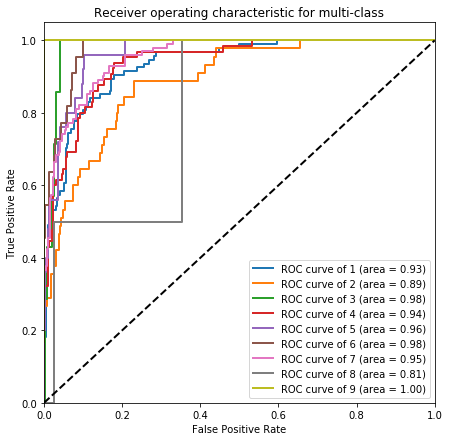

In [152]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
classnames = [1,2,3,4,5,6,7,8,9]
y_actual_binary = label_binarize(y_test, classes=classnames)
y_pred_binary = y_prob #label_binarize(predicted, classes=classnames)
n_classes=9
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

colors = cycle(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", \
                "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

In [154]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


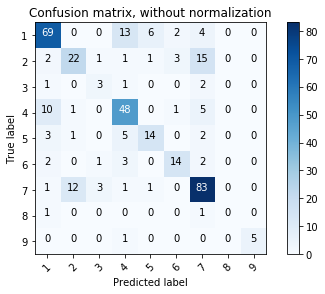

<Figure size 432x288 with 0 Axes>

In [155]:
cnf_matrix= confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(1,10)],
                      title='Confusion matrix, without normalization')
plt.figure()
plt.show()